In [62]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
import matplotlib.pyplot as plt

#  CEvNS rate

In this notebook I will work out how to calculate the CEvNS rate (initially in xenon, following Jay's code), before writing it into a single script

I will start by just taking one of the fluxes calculated from the spectrum generator, but eventually it might be more useful to just define a spectrum function based on that code

The rate calculation takes the following form:
* Integrate over Enu from Enu_min to 8 MeV, using:
* - Enu_min(E_R, isotope properties)
* Integrand multiplies the:
* - flux (fn of Enu)
* - isotope abundance (of Xe)
* - CEvNS rate
* Overall normalisation factor uses the:
* - flux normalisation (fn of distance from reactor)
* - mass of xenon

I will also follow Jay's practice in being consistent with units by making everything in terms of GeV

## Constants

In [2]:
GeV = 1
MeV = 1e-3*GeV
keV = 1e-6*GeV
eV = 1e-9*GeV
hbarc = 0.19732698 # GeV fm
speed_of_light = 2.997925e8 # m/s
Gf = 1.166378e-5/GeV**2
electron_charge = 1.60217663e-19 # coulombs
amu = 0.931494

METER = 1e15/hbarc
CENTIMETER = 1e-2*METER
SECOND = speed_of_light*METER
YEAR = 60*60*24*365.25*SECOND
JOULE = eV/electron_charge
GW = 1e9*JOULE/SECOND
KILOGRAM = speed_of_light**2*JOULE
KILOGRAMDAY = KILOGRAM*(60*60*24*SECOND)
CM2S = CENTIMETER**2*SECOND

In [3]:
xe124 = {"Z": 54, "A": 124, "abundance": 0.00095, "mass": 123.906*amu}
xe126 = {"Z": 54, "A": 126, "abundance": 0.00089, "mass": 125.904*amu}
xe128 = {"Z": 54, "A": 128, "abundance": 0.0191, "mass": 127.904*amu}
xe129 = {"Z": 54, "A": 129, "abundance": 0.26401, "mass": 128.905*amu}
xe130 = {"Z": 54, "A": 130, "abundance": 0.04071, "mass": 129.904*amu}
xe131 = {"Z": 54, "A": 131, "abundance": 0.21232, "mass": 130.905*amu}
xe132 = {"Z": 54, "A": 132, "abundance": 0.26909, "mass": 131.904*amu}
xe134 = {"Z": 54, "A": 134, "abundance": 0.10436, "mass": 133.905*amu}
xe136 = {"Z": 54, "A": 136, "abundance": 0.08857, "mass": 135.907*amu}
isotopesXe = [xe124, xe126, xe128, xe129, xe130, xe131, xe132, xe134, xe136]

mXe = 131.293*amu

In [5]:
Qp = 0.0747
Qn = -1.0235

## Kinematics

In [64]:
def Enu_min(ER, mT):
    return 0.5*(ER + (ER**2 + 2*ER*mT)**0.5)

## CEvNS cross section

In [76]:
def Fhelm(q, A):
    s = 0.9
    r = ( (1.23*A**(1/3) - 0.6)**2 + (7/3)*np.pi**2*0.52**2 - 5*s**2 )**0.5
    return 3 * ( np.sin(q*r/hbarc) - (q*r/hbarc)*np.cos(q*r/hbarc) ) / ( q*r/hbarc )**3 * np.exp( -1*(q*s/hbarc)**2/2 )

def dsigma_dER(ER, Enu, isotope):
    mT = isotope["mass"]
    Z = isotope["Z"]
    A = isotope["A"]


    prefactor = (Gf**2 * isotope["mass"]) / (4*np.pi)
    kinematic_factor = 1 - (ER/Enu) - (ER*mT)/(2*Enu**2)
    weak_charge = Z*Qp + (A-Z)*Qn
    q = (2*mT*ER)**0.5

    return prefactor * kinematic_factor * weak_charge**2 * Fhelm(q, A)

## Fluxes

Eventually the goal will be to write code here that generates spectra for given reactor properties, but for now I will just import fluxes calculated using the spectrum generator code

In [43]:
def get_spectrum(filename):
    energies = []
    fluxes = []

    for line in open(filename):
        if not line.startswith("#"):
            line=line.strip("\n")
            lineParts=line.split(",")
            energies.append(float(lineParts[0]))
            fluxes.append(float(lineParts[1]))
    
    return (np.array(energies)*MeV, np.array(fluxes)/SECOND/MeV) # this is to put it in units in terms of GeV. Might not be needed if I edit the spectrum generation code

In [44]:
TRIGA_flux_data = get_spectrum('spectra/TRIGA_flux.text')
Kaixuan_flux_data = get_spectrum('spectra/Kaixuan_flux.text')
HFIR_flux_data = get_spectrum('spectra/HFIR_flux.text')

In [70]:
TRIGA_flux = interp1d(*TRIGA_flux_data, kind="cubic")
Kaixuan_flux = interp1d(*Kaixuan_flux_data, kind="cubic")
HFIR_flux = interp1d(*HFIR_flux_data, kind="cubic")

## CEvNS rate in xenon

In [131]:
def flux_norm(L):
    return 1/(4*np.pi*L**2)

def dR_dER_Xe(flux, L, ER):

    def integrand(Enu, isotope):
        return flux(Enu) * isotope["abundance"] * dsigma_dER(ER, Enu, isotope)

    def unnormalised_rate_per_isotope(isotope):
        integral = quad(integrand, Enu_min(ER, isotope["mass"]), 8*MeV, args=(isotope))
        # print(integral[1]/integral[0])
        return integral[0]

    return (flux_norm(L)/mXe)*sum([unnormalised_rate_per_isotope(isotope) for isotope in isotopesXe])

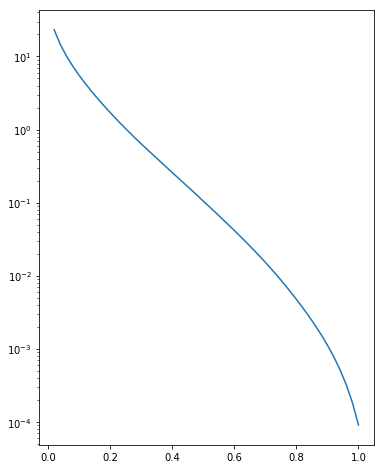

In [139]:
fig, ax = plt.subplots(figsize=(6,8))

ER_array = np.linspace(0.02, 1, 50)
rates = [dR_dER_Xe(TRIGA_flux, 5*METER, ER*keV)*KILOGRAMDAY*keV for ER in ER_array]

ax.plot(ER_array, rates)

ax.set_yscale('log')